This is a general purpose image classifier that can be applied to datasets that have the data organized as shown below. To use this code select Run all. The code will prompt the user to provide the required input data. It will take only a minute or so to enter the data and your model will be up and training. I have used this code on numerous data sets with excellent results. The model will initially run for 10 epochs. After 10 epochs you are prompted to enter H to halt training or you can enter an integer that specifies how many more epochs to run. After those epochs complete you will be again prompted to continue or halt training. The code shows the % decreasee  of the validation loss at the end of each epoch. This is a good guide to use to decide to continue or halt training. As you near the bottom of the loss function the % decrease in loss becomes smaller. I typically halt training when the % decrease falls below 5%. However sometimes it is best to continue training until the loss increases. The code then automatically lowers the learning rate. This often enables the model to again start decreasing the loss. Your saved model is always returned with the weights set to those for the epoch with the lowest loss.   

data directory  
* train directory    
  * class 0 
     * image 0 
     * image 1
     * ......
     * image m
  * class 1
     * image 0 
     * image 1
     * ......
     * image n 
  * ......
  * class m
     * image 0 
     * image 1
     * ......
     * image r 
* valid directory ( optional if there is no validation directory validation data is created by partition of train data)  
   * class 0 
     * image 0 
     * image 1
     * ......
     * image x
   * class 1
     * image 0 
     * image 1
     * ......
     * image y 
   * ......
   * class m
     * image 0 
     * image 1
     * ......
     * image z
* test directory ( optional if there is no test directory test data is created by partition of train data)  
   * class 0 
     * image 0 
     * image 1
     * ......
     * image a
   * class 1
     * image 0 
     * image 1
     * ......
     * image b 
   * ......
   * class m
     * image 0 
     * image 1
     * ......
     * image c

### Recently Kaggle updated its docker file to load tensorflow 2.11.0. where before it loaded version 2.9.2 . However version 2.10.0 and above have a bug with respect to saving EfficientNet models. In my code if you select a medium or large model, the result is an EfficientNetB0 or B3 model is generated. So when you try to save the model you will receive a message saying the model can not be saved. If you want to save your model, uncomment the code line below which will install tensorflow version 2.9.2.

## [1. Import Needed Modules](#import) ##
## [2 Define a function to print text in color](#pc) ##
## [3. Define a function to plot the number of images in dataset classes](#pcounts) ##
## [4 Define a function to return information on the dataset](#check) ##
## [5. Read in images and create a dataframe of image paths and class labels](#makedf) ## 
## [6. Define a function that trims a dataset for the max number of class images](#trim) ## 
## [7. Balance the trainning set using augmentation](#Balance) ##
## [8. Create train, test and validation generators](#gens) ## 
## [9. Create a function to show Training Image Samples](#show) ## 
## [10 Create a function to calculate the F1 score metric](#f1metric) ##
## [11. Create the Model](#model) ## 
## [12. Create a custom Keras callback to continue or halt training](#callback) ## 
## [13. Define a function to plot the training data](#plot) ##
## [14. Define a function save the training data to a csv file](#csv) ##
## [15. Define a function to make predictions on the test set](#predict) ##
## [16. Make predictions on test set, create Confusion Matrix and Classification Report](#result) 
## [17. Define a function to save the trained model ](#save) ##
## [18 Define the run function which runs the classifier](#run) ##
## [19 Define the code to enable to initiate the run function](#cycle) ##
## [20. Evaluate Model Performance](#Conclusions) ## 

In [165]:
 #pip install tensorflow==2.9.2

<a id="import"></a>
## <center>Import required modules</center>

In [166]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import albumentations as A
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

In [167]:
print('tensor version is ', tf.__version__)

tensor version is  2.9.2


<a id="pc"></a>
## <center>Define a function to print text in specified rgb foreground and background colors</center>
### Add some PZAZZ to your printed output with this function  
form of the call is:  print_in_color(txt_msg, fore_tupple, back_tupple where:
* txt_msg is the string to be printed out  
* fore_tuple is tuple of the form (r,g,b) specifying the foreground color of the text
* back_tuple is tuple of the form (r,g,b) specifying the background color of the text

In [168]:
# for kaggle uae (0,0,0) and (255,255,255)
def print_in_color(txt_msg,fore_tupple= (64, 64, 64) ,back_tupple=(230, 230, 230)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat))
    print('\33[0m', end='') # returns default print color to back to black

<a id="pcounts"></a>
## <center>Define a function that plots value counts for a column in a dataframe</center>

In [169]:
def plot_label_count (df, plot_title):
    column='labels'
    xaxis_label='CLASS'
    yaxis_label='IMAGE COUNT'
    vcounts=df[column].value_counts()
    labels=vcounts.keys().tolist()    
    values=vcounts.tolist() 
    lcount=len(labels)
    if lcount>55:
        print_in_color('The number of labels is >55, no plot will be produced')
    else:
        width=lcount * 4
        width=np.min([width, 10])
        plt.figure(figsize=(width,5)) 
        form = {'family': 'serif', 'color': 'green', 'size': 15} 
        plt.bar(labels, values)
        plt.title(plot_title, fontsize= 20, color='green')
        plt.xticks(rotation=90, fontsize=10)
        plt.yticks(fontsize=10)
        plt.xlabel(xaxis_label, fontdict=form)
        plt.ylabel(yaxis_label, fontdict=form)
        if lcount >=8:
            rotation='vertical'
        else:
            rotation='horizontal'
        for i in range(lcount):
            plt.text(i, values[i]/2, str(values[i]),fontsize=12, rotation=rotation, color='black', ha='center')        
        plt.show()

<a id="check"></a>
# <center>Define a function to return information of the training data</center>
* train_dir is a string specifying the full path to the directory holding the training images
The function determines the total number of training images, the class with the most image files      
and their number and the class with the least image files and their number. This information is      
provided to the used to enable selection of various program parameters

In [170]:
def check_dataset_size(train_dir):
    classes=sorted(os.listdir(train_dir))
    ftotal=0
    flargest=0
    fsmallest=100000000
    for klass in classes:
        classpath=os.path.join(train_dir,klass)
        if os.path.isdir(classpath):
            flist=os.listdir(classpath)
            fcount=len(flist)
            if fcount>flargest:
                flargest=fcount
                maxclass=klass
            if fcount < fsmallest:
                fsmallest=fcount
                minclass=klass
            ftotal += fcount
    return ftotal, flargest, maxclass, fsmallest, minclass

<a id="makedf"></a>
# <center>Read in data and create train, test and validation data frames</center>


In [171]:
def make_dataframes(train_dir,test_dir, val_dir, limiter):
    bad_images=[]
    # check what directories exist
    if test_dir == None and val_dir==None:
        dirlist=[train_dir]
        names = ['train']
    elif test_dir == None:
        dirlist=[train_dir,  val_dir]
        names=['train', 'valid']
    elif val_dir == None:
        dirlist=[train_dir,  test_dir]
        names=['train', 'test'] 
    else:
        dirlist=[train_dir, test_dir, val_dir]
        names=['train','test', 'valid']
    ht=0 # set initial value of height counter
    wt=0  # set initial value of width counter
    total_good_files=0 # set initial value of total number of good image files counter
    zipdir=zip(names, dirlist)
    for name,d in zipdir: #iterate through the  names and directories
        filepaths=[] # initialize list of filepaths
        labels=[] # initialize list of class labels
        classlist=sorted(os.listdir(d) )   # get a list of all the classes in alphanumeric order   
        for klass in classlist: # iterate through the list of classes
            msg=f'processing images in {name} directory for class {klass}                                                  '
            print(msg, '\r', end='')
            good_file_count=0 # initialize the good_file count for this class
            classpath=os.path.join(d, klass) # define the full path to the class            
            if os.path.isdir(classpath): # ensure we are working with a directory and not a spurious file
                flist=sorted(os.listdir(classpath)) # make a list of all the files for this class
                if limiter != None: # check if a limiter value was specified that determmine how many files to use in any class
                    if limiter <len(flist): # if there are more files than the value of limiter than randomly sample a limiter number of files
                        flist=np.random.choice(flist, limiter, replace=False)                        
                for f in flist:
                    fpath=os.path.join(classpath,f) # create the full path to the image file
                    index=f.rfind('.')
                    ext=f[index+1:].lower() # the the file's extension
                    if ext not in ['jpg', 'jpeg', 'tiff', 'png', 'bmp'] :   # make sure the file extension is one that works with Keras                     
                        bad_images.append(fpath) # if not a proper extension store the filepath in the bad images list
                    else:                    
                        try: # check if image files are defective if so do not include in dataframe
                            img=cv2.imread(fpath)
                            h=img.shape[0]
                            w=img.shape[1]
                            ht +=h # add images height and width to the counters
                            wt += w                    
                            good_file_count +=1   
                            total_good_files +=1
                            filepaths.append(fpath) # append the filepath to the list of valid filepaths
                            labels.append(klass) # append the file's class label to the labels list

                        except:
                            bad_images.append(fpath) # if the image file is defective add the filepath to the list of bad images
        print('')
        Fseries=pd.Series(filepaths, name='filepaths') # make a pandas series for the filenames and labels lists
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1) # make a dataframe with columns filepaths and labels
        # depending on which directory we are iterating through create dataframes
        if name =='valid':
            valid_df=df
        elif name == 'test':
            test_df=df
        else:
            if test_dir == None and val_dir == None: # create train_df, test_df and valid_df from df
                pdf=df
                train_df, dummy_df=train_test_split(pdf, train_size=.8, shuffle=True, random_state=123, stratify=pdf['labels'])
                valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
            elif test_dir == None: # create just a train_df and test_df 
                pdf=df
                train_df,test_df=train_test_split(pdf, train_size=.8, shuffle=True, random_state=123, stratify=pdf['labels'])
            elif val_dir == None:  # create a train_df and a valid_df                          
                pdf=df                
                train_df,valid_df=train_test_split(pdf, train_size=.8, shuffle=True, random_state=123, stratify=pdf['labels'])
            else:
                train_df= df # test and valid dataframes exists so train_df is just df
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)    
    # calculate the average image height and with 
    have=int(ht/total_good_files)
    wave=int(wt/total_good_files)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts())    
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df)) 
    if len(bad_images) == 0:
        print_in_color('All image files were properly processed and used in the dataframes')
    else:
        print_in_color(f'the are {len(bad_images)} bad image files and {total_good_files} proper image files in the dataset')
        for f in bad_images:
            print (f)                       
    plot_title='Images per Label in train set'
    plot_label_count (train_df,  plot_title)
    return train_df, test_df, valid_df, classes, class_count, max(counts), min(counts), have, wave

<a id="trim"></a>
## <center>Define a function that trims the classes in a dataframe</center>
* df is the dataframe
* max_samples is an integer specifies the maximum number of images a class can have
* min_samples is an integer specifying the minimum number of images a class must have to be included in the trimmed dataframe
* column is a string specifying the column name in the dataframe holding the class labels 

In [172]:
def trim(df, max_samples, min_samples, column):
    # column specifies which column of the dataframe to use, typically this is the labels column
    # df is typically train_df
    df=df.copy()
    classes=df[column].unique() # get the classes in df
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)   # creates a set of  dataframes that only contains rows that have the class label  
    trimmed_df = pd.DataFrame(columns = df.columns) # create an empty dataframe with columns filepaths, labels    
    for label in df[column].unique(): # iterate through each class label
        group=groups.get_group(label) # get the dataframe associate with the label
        count=len(group) # determine how many files are in the dataframe   
        if count > max_samples: # if there more files in the dataframe sample it so the sampled files has only n rows
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0) # add the sampled files to the trimmed_df dataframe
        else:
            if count>=min_samples: # if the dataframe has more than the minimum number of files include it in the dataset
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples and so will have less classes in it
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count



<a id="balance"></a>
## <center>Expand train_df rows with augmented images so each class has n samples</center>
* df is the dataframe
* n is an integer specifying the number of images desired for each class
* column is a string specifying the column name of the dataframe that contains the class labels
* working_dir is a string specifying the path where augmented images will be stored
* img_size is a tupple (height,width) specifying the image size of the augmented images created

In [173]:
def balance(df, n,column, working_dir, img_size):    
    def get_augmented_image(image): # given an image this function returns an augmented image
        width=int(image.shape[1]*.8)
        height=int(image.shape[0]*.8)
        transform= A.Compose([
            A.HorizontalFlip(p=.5),
            A.Rotate(limit=30, p=.25),
            A.RandomBrightnessContrast(p=.5),
            A.RandomGamma(p=.5),
            A.RandomCrop(width=width, height=height, p=.25) ])    
        return transform(image=image)['image']
    def dummy(image):
        return image

    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df[column].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images  
    total=0    
    groups=df.groupby(column) # group by class
    for label in df[column].unique():  # for every class
        msg=f'augmenting images in train set  for class {label}                                              '
        print(msg, '\r', end='')        
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images            
            desc=f'augmenting class {label:25s}'
            for i in range(delta):                
                j= i % sample_count # need this because we may have to go through the image list several times to get the needed number
                img_path=group['filepaths'].iloc[j]
                img=cv2.imread(img_path)
                img=get_augmented_image(img)
                fname=os.path.basename(img_path)
                fname='aug' +str(i) +'-' +fname
                dest_path=os.path.join(target_dir, fname)                
                cv2.imwrite(dest_path, img)
                aug_img_count +=1
            total +=aug_img_count
    print('')
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=sorted(os.listdir(aug_dir))
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=sorted(os.listdir(classpath))    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')   
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))    
    return df 

<a id="gens"></a>
# <center>Create the train_gen, test_gen  and valid_gen</center>
* batch_size is an integer specifying the generator batch size
* ycol is a string specifying the dataframe column containing the class labels
* train_df is the dataframe containing the training images
* test_df is the dataframe containing the test images
* valid_df is the dataframe containing the validation images
* image_size is a tupple (height, width)

In [174]:
def make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size):
    gen=ImageDataGenerator() 
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=gen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)    
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels    
    return train_gen, test_gen, valid_gen, test_steps, class_count

<a id="show"></a>
# <center>Create a function to show example training images</center>
* gen is the ImageDataGenerator containing the images to be displayed

In [175]:
def show_image_samples(gen ):
    msg='Below are some example training images'
    print_in_color(msg)
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<15:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='green', fontsize=18)
        plt.axis('off')
    plt.show()

<a id="f1metric"></a>
# <center>Create a function to calculate the F1 score metric</center>
* y_true is an np array containing the true integer index of  the associated image file
* y_pred is an np array containing the predicted integer index of a test image in the test dataframe

In [176]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

<a id="model"></a>
## <center>Create a small, medium or large model using transfer learning </center>
* img_size is a tupple (height, width)
* class_count is an integer that specifies the number of classes in the dataset
* lr is a float specifying the intial model's learning rate
* ans is a string. If ans is an empty string an EfficientNetB0 model is used for transfer learning,  
  is ans='S' a MobilenetV3-small model is used for transfer learning. If ans='L' an 
  EfficientNetB3 model is used for transfer learning

In [177]:

def make_model(img_size, class_count, lr, ans):
    img_shape = (img_size[0], img_size[1], 3)
    if ans == 's' or ans == 'S':
        base_model = tf.keras.applications.MobileNetV3Small(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        msg = 'Created MobileNet V3 Small model'
    elif ans == 'l' or ans == 'L':
        base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        msg = 'Created EfficientNet B3 model'
    elif ans == 'i' or ans == 'I':
        base_model = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        msg = 'Created Inception V3 model'
    else:
        base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        msg = 'Created EfficientNet B0 model'

    base_model.trainable = True
    x = base_model.output
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
    x = Dropout(rate=0.4, seed=123)(x)
    output = Dense(class_count, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', F1_score])
    msg = msg + f' with initial learning rate set to {lr}'
    print_in_color(msg)
    return model


<a id="callback"></a>
# <center>Create a custom Keras callback to continue or halt training</center>
The LR_ASK callback is a convenient callback that allows you to continue training for ask_epoch more epochs or to halt training.  
If you elect to continue training for more epochs you are given the option to retain the current learning rate (LR) or to  
enter a new value for the learning rate. The form of use is:  
ask=LR_ASK(model,epochs, ask_epoch) where:  
* model is a string which is the name of your compiled model
* epochs is an integer which is the number of epochs to run specified in model.fit
* ask_epoch is an integer. If ask_epoch is set to a value say 5 then the model will train for 5 epochs.  
  then the user is ask to enter H to halt training, or enter an inter value. For example if you enter 4  
  training will continue for 4 more epochs to epoch 9 then you will be queried again. Once you enter an  
  integer value you are prompted to press ENTER to continue training using the current learning rate  
  or to enter a new value for the learning rate.
 * dwell is a boolean. If set to true the function compares the validation loss for the current tp the lowest   
   validation loss thus far achieved. If the validation loss for the current epoch is larger then learning rate  
   is automatically adjust by the formulanew_lr=lr * factor where factor is a float between 0 and 1. The motivation  
   here is that if the validation loss increased we have moved to a point in Nspace on the cost functiob surface that  
   if less favorable(higher cost) than for the epoch with the lowest cost. So the model is loaded with the weights
   from the epoch with the lowest loss and the learning rate is reduced
  
 At the end of training the model weights are set to the weights for the epoch that achieved the lowest validation loss

In [178]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, batches, dwell=True, factor=.4): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1        
        self.dwell= dwell
        self.factor=factor
        self.header=True
        self.batches=batches
    
    def on_train_begin(self, logs=None): # this runs on the beginning of training 
        msg1 =f'Training will proceed until epoch {self.ask_epoch} then you will be asked to\n'
        msg2='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
        print_in_color(msg1 + msg2)
        if self.dwell:
            msg='learning rate will be automatically adjusted during training'
            print_in_color(msg, (0,255,0))
        self.start_time= time.time() # set the time at which training started
       
    def on_train_end(self, logs=None):   # runs at the end of training  
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0,255,255))
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # print out training duration time
   
    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()
    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')
        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        if self.header == True:
            msg = '{0:^7s}{1:^9s}{2:^9s}{3:^9s}{4:^10s}{5:^13s}{6:^10s}{7:^13s}{8:13s}\n'
            msg1=msg.format('Epoch', 'Train', 'Train', 'Valid', 'Valid','V_Loss %', 'Learning','Next LR' ,'Duration in')
            msg='{0:^7s}{1:^9s}{2:^9s}{3:^9s}{4:^10s}{5:^13s}{6:^10s}{7:^13s}{8:13s}'
            msg2=msg.format(' ', 'Loss', 'Accuracy', 'Loss', 'Accuracy','Improvement', 'Rate', 'Rate', '  Seconds') 
            print_in_color (msg1 + msg2)
            self.header=False
        ep_end = time.time()
        duration = ep_end - self.ep_start        
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100            
        else:
            pimprov=0.0             
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1 
            new_lr=lr
            msg = '{0:^7s}{1:^9.4f}{2:^9.2f}{3:^9.4f}{4:^10.2f}{5:^13.2f}{6:^10.6f}{7:11.6f}{8:^15.2f}'
            msg=msg.format(str(epoch+1), aloss, acc*100, vloss, v_acc*100, pimprov, lr, new_lr,duration)         
            print_in_color(msg, (0,255,0)) # green foreground
        else: # validation loss increased                     
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg = '{0:^7s}{1:^9.4f}{2:^9.2f}{3:^9.4f}{4:^10.2f}{5:^13.2f}{6:^10.6f}{7:11.6f}{8:^15.2f}'                 
                msg=msg.format(str(epoch+1), aloss, acc*100, vloss, v_acc*100, pimprov, lr, new_lr,duration) 
                print_in_color(msg, (255,255,0))                
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                self.model.set_weights(self.best_weights) # set the weights of the model to the best weights                 
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?                
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) # cyan foreground
                ans=input()
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.header=True
                    self.ask_epoch += int(ans)
                    msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                    print_in_color(msg) # cyan foreground
                    if self.dwell==False:
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                        print_in_color(msg) # cyan foreground
                        ans=input(' ')
                        if ans =='':
                            msg=f'keeping current LR of {lr:7.5f}'
                            print_in_color(msg) # cyan foreground
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            msg=f' changing LR to {ans}'
                            print_in_color(msg) # cyan foreground

<a id="plot"></a>
# <center>Define a function to plot the training data</center>
* tr_data is the history data from model.fit

In [179]:
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['F1_score']
    vf1=tr_data.history['val_F1_score']    
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    indexf1=np.argmax(vf1)
    vf1_highest=vf1[indexf1]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch) 
    f1_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=(15,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'green', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='orange')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=10)
    axes[0].set_ylabel('Loss', fontsize=10)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='orange')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'green', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=10)
    axes[1].set_ylabel('Accuracy', fontsize=10)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')    
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)# thisiis the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'green', label=vc_label)    
    axes[2].scatter(Epochs, tf1, s=100, c='orange')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=10)
    axes[2].set_ylabel('F1  score', fontsize=10)
    axes[2].legend()    
    plt.tight_layout    
    plt.show()
    return 

<a id="csv"></a>
# <center>Define a function to save the training data to a csv file</center>
* history is the history from history=model.fit
* csvpath is a string specifying the full path where the csv file will be stored

In [180]:
def save_history_to_csv(history,csvpath):
    trdict=history.history 
    df=pd.DataFrame() 
    df['Epoch']=list(np.arange(1, len(trdict['loss']) + 1 ))
    keys=list(trdict.keys())     
    for key in keys:
        data=list(trdict[key])        
        df[key]=data   
    df.to_csv(csvpath, index=False)

<a id="predict"></a>
## <center>Make Predictions on the test set</center>
### Define a function which takes in a trained model and a test generator  and generates predictions  
### on the test set including a confusion matrix and a classification report
* model is the trained model
* test_gen is the ImageDataGenerator holding the test filepaths and labels
The function will produce a classification report, a confusion matrix and a plot of misclassifications

In [181]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


def predictor(model,test_gen):
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    preds=model.predict(test_gen, verbose=1)
    errors=0
    test_count =len(preds)
    misclassified_classes=[]
    misclassified_files=[]
    misclassified_as = []
    pred_indices=[]
    for i, p in enumerate (preds):
        pred_index=np.argmax(p)
        pred_indices.append(pred_index)
        true_index= test_gen.labels[i]    
        if  pred_index != true_index:        
            errors +=1        
            misclassified_classes.append(classes[true_index])
            misclassified_as.append(classes[pred_index])
            file=test_gen.filenames[i]
            split=file.split('/')
            L=len(split)           
            f=split[L-2] +' '+ split[L-1]  
            misclassified_files.append(f)

    accuracy = (test_count-errors)*100/test_count
    ytrue=np.array(test_gen.labels)
    ypred=np.array(pred_indices)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    msg=f'There were {errors} errors in {test_count} tests for an accuracy of {accuracy:6.2f} and an F1 score of {f1score:6.2f}'
    print (msg) 
    misclassified_classes=sorted(misclassified_classes)
    if len(misclassified_classes) > 0:
        misclassifications=[]
        for klass in misclassified_classes:
            mis_count=misclassified_classes.count(klass)
            misclassifications.append(mis_count)
        unique=len(np.unique(misclassified_classes)) 
        if unique==1:
            height=int(unique)
        else:
            height =int(unique/2)
        plt.figure(figsize=(8, height))
        plt.style.use('fivethirtyeight')
        plt.barh(misclassified_classes, misclassifications )
        plt.title( 'Classification Errors on Test Set by Class', fontsize=8, color='green')
        plt.xlabel('NUMBER OF MISCLASSIFICATIONS', fontsize=8, color='green')
        plt.ylabel('CLASS', fontsize=8, color='green')
        plt.show()
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Greens', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
        clr = classification_report(ytrue, ypred, target_names=classes, digits= 4) # create classification report
        print("Classification Report:\n----------------------\n", clr)
        y_true = label_binarize(test_gen.labels, classes=range(class_count))
        y_pred = model.predict(test_gen, verbose=1)

        # Calculate ROC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(class_count):
            fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot all ROC curves
        plt.figure()
        for i in range(class_count):
            plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic for each class')
        plt.legend(loc="lower right")
        plt.show()


    return f1score
        
  

<a id="save"></a>
# <center>Save the model </center>

In [182]:
def save_model(model,subject, classes, img_size, f1score, working_dir):    
    name=f'{subject}-{str(len(classes))}-({str(img_size[0])} X {str(img_size[1])})- {f1score:5.2f}.h5'    
    model_save_loc=os.path.join(working_dir, name)
    try:
        model.save(model_save_loc)        
        msg= f'model was saved as {model_save_loc}'
        print_in_color(msg, (0,255,255),(0,0,0))
    except:
        msg='model can not be saved due to tensorflow 2.10.0 or higher. Bug involving use of EfficientNet Models'        
        print_in_color(msg, (0,255,255), (0,0,0)) # cyan foreground

<a id="run"></a>
# <center>Define a function that runs the classifier</center>
This is the code that provides the interface to the user and calls the various defined functions based on the users input. To follow how the program works start here. You can run this function as many times as you care to if you want to do runs with various different parameters. You can save the data from each run in a csv file to compare training and validation results from different runs. 

In [183]:
def run(working_dir= None,train_dir=None, test_dir=None, valid_dir=None,start=True):
    if start:
        msg='enter the full path to the working directory where data will be stored.'
        print_in_color(msg)
        working_dir=input(' ')
        if 'kaggle' in working_dir: # if running the notebook on kaggle need to modify so parameters
            delimiter='/'
        else:
            delimiter='\\'
        msg='Enter the full path to the train directory'
        print_in_color(msg)
        train_dir =input(' ')
        msg = 'Enter the full path to the validation directory. If there is no validation directory press enter'
        print_in_color(msg)
        ans=input(' ')
        if ans == '':
            valid_dir=None
        else:
            valid_dir=ans
        msg = 'Enter the full path to the test directory. If there is no test directory press enter'
        print_in_color(msg)
        ans=input(' ')
        if ans == '':
            test_dir=None
        else:
            test_dir=ans
                                                      
    ftotal, flargest, maxclass , fsmallest, minclass= check_dataset_size(train_dir) # get info on training data
    msg1= f'the train directory contains {ftotal} files, class {maxclass} has the most images of {flargest} files\n'
    msg2= f'class {minclass} contains the least number of images of {fsmallest} files\n'
    msg3= f'NOTE if the value of most images is the same as the value of least images the dataset is balanced\n'
    msg4='When dealing with very large data sets to save time you may not want to read in all the image files\n'
    msg5 ='to limit the maximum number of image files in any class you can enter an integer limiter value'
    msg=msg1 +msg2 + msg3 + msg4 + msg5
    print_in_color(msg) # print the training data information for the user
    msg = 'input a limiter integer value to limit max number of images in a class, for no limit hit enter'
    print_in_color(msg)
    limiter=input(' ')
    if limiter == '':
        limiter = None
        msg='dataset will be processed as is with no limiter'
        print_in_color(msg)
    else:
        limiter=int(limiter)
        msg=f'images will be limited to a maximum of {limiter} images in each class'
        print_in_color(msg) 
    # create train, test and valid data frames
    train_df, test_df, valid_df, classes, class_count, max_samples, min_samples, have, wave=make_dataframes(train_dir,test_dir, valid_dir, limiter)
    msg=f'the average height of training images is {have} and average width is {wave}\n  enter the image height to be used to train the model'            
    print_in_color(msg)
    img_height=int(input(' '))
    msg=' Enter the image width to be used to train the model' 
    print_in_color(msg)
    img_width=int(input(' '))
    img_size=(img_height, img_width)
    msg=f'model will be trained with image shape of  ( {img_height}, {img_width} )'    
    print_in_color(msg)
    # determine if user wants to balance the training dataframe
    msg=' enter A  to auto balance the train set or enter or hit enter to leave train set unchanged  '
    print_in_color(msg)
    ans=input(' ')
    if ans == 'A' or ans =='a':
        msg='enter the number of images you want to have in each class of the train data set'
        print_in_color(msg)
        max_images=int(input(' '))  
        train_df, classes, class_count=trim (train_df, max_images, min_samples, 'labels') # trim the dataset for max images in a class
        train_df=balance(train_df, max_images, 'labels', working_dir, img_size) # balance the training data with augmented images   
        plot_title='Images per Label after Auto Balance of train data set'
        plot_label_count (train_df,  plot_title)  # plot the number of images in each class of the training set        
    else:        
        msg=f'training data set will be used as is '
        print_in_color (msg)  
    classes=list(train_df['labels'].unique())
    class_count = len(classes)
    # make train, test and valid data generators
    msg='enter the desired batch size or press enter to use the default batch size of 20  '
    print_in_color(msg)
    ans=input(' ')
    if ans =='':
        bs=20
    else:
        bs=int(ans)
    # make the train, test and valid data generators
    train_gen, test_gen, valid_gen, test_steps, class_count= make_gens(bs, 'labels', train_df, test_df, valid_df, img_size)
    show_image_samples(train_gen ) # show some sample training images
    msg='select model size enter S for small, L for large or hit enter (recommended) for medium size model'
    print_in_color(msg)
    print('',end='')
    ans=input(' ')
    # make the model
    model = make_model(img_size,class_count, .001, ans) # create the model
    epochs=100
    ask_epoch=10
    batches=int(len(train_df)/bs)
    # instantiate the custom callback
    ask=LR_ASK(model, epochs=epochs,  ask_epoch=ask_epoch, batches=batches) # instantiate the custom callback
    callbacks=[ask]    
    # train the model
    history=model.fit(x=train_gen,   epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
                   validation_steps=None,  shuffle=True,  initial_epoch=0) # train the model
    
    tr_plot(history) # plot training data
    msg='To save the training data to a csv file enter the name for the csv file or press enter to not save the data'
    print_in_color(msg)
    ans=input(' ')
    if ans !='': # save the training data to a csv file history.csv in working directory
        csvpath=os.path.join(working_dir, ans + '.csv')
        save_history_to_csv(history,csvpath)
        msg=f'training data saved to {csvpath}'
        print_in_color(msg)
    # make predictions on the test set, create classification report and confusion matrix
    f1score=predictor(model,test_gen) # do predictions on test set and generate reports 
    # save the model
    msg=f'your trained model will be saved to directory {working_dir} enter a subject for the saved model'
    print_in_color(msg)
    subject=input(' ')
    save_model(model,subject, classes, img_size, f1score, working_dir) # save the model to the working directory
    msg='model save nomenclature is directory/subject-number of classes- (img_height, img_width)- F1score.h5'
    print_in_color(msg) 
    # remove the aug directory from the working directory
    if os.path.isdir(os.path.join(working_dir, 'aug')):
        shutil.rmtree(os.path.join(working_dir, 'aug')) #remove the augmentation directory it is no longer needed
    return working_dir,train_dir, test_dir, valid_dir

<a id="cycle"></a>
# <center>Initiate the run function and enable ability to execute run  multiple times</center>
The code below initiate the first run of the classifier and lets the user rerun the classifier

enter the full path to the working directory where data will be stored.


  /kaggle/working/


Enter the full path to the train directory


  /kaggle/input/5eye-disease-clahe-y-channel-and-gaussian-blurring/updated_5 classes eye disease preprosed image/train


Enter the full path to the validation directory. If there is no validation directory press enter


  /kaggle/input/5eye-disease-clahe-y-channel-and-gaussian-blurring/updated_5 classes eye disease preprosed image/val


Enter the full path to the test directory. If there is no test directory press enter


  /kaggle/input/5eye-disease-clahe-y-channel-and-gaussian-blurring/updated_5 classes eye disease preprosed image/test


the train directory contains 3453 files, class diabetic_retinopathy has the most images of 878 files
class retina_disease contains the least number of images of 80 files
NOTE if the value of most images is the same as the value of least images the dataset is balanced
When dealing with very large data sets to save time you may not want to read in all the image files
to limit the maximum number of image files in any class you can enter an integer limiter value
input a limiter integer value to limit max number of images in a class, for no limit hit enter


dataset will be processed as is with no limiter
processing images in train directory for class retina_disease                                                         
processing images in test directory for class retina_disease                                                         
processing images in valid directory for class retina_disease                                                         
number of classes in processed dataset=  5
the maximum files in any class in train_df is  878   the minimum files in any class in train_df is  80
train_df length:  3453   test_df length:  437   valid_df length:  427
All image files were properly processed and used in the dataframes


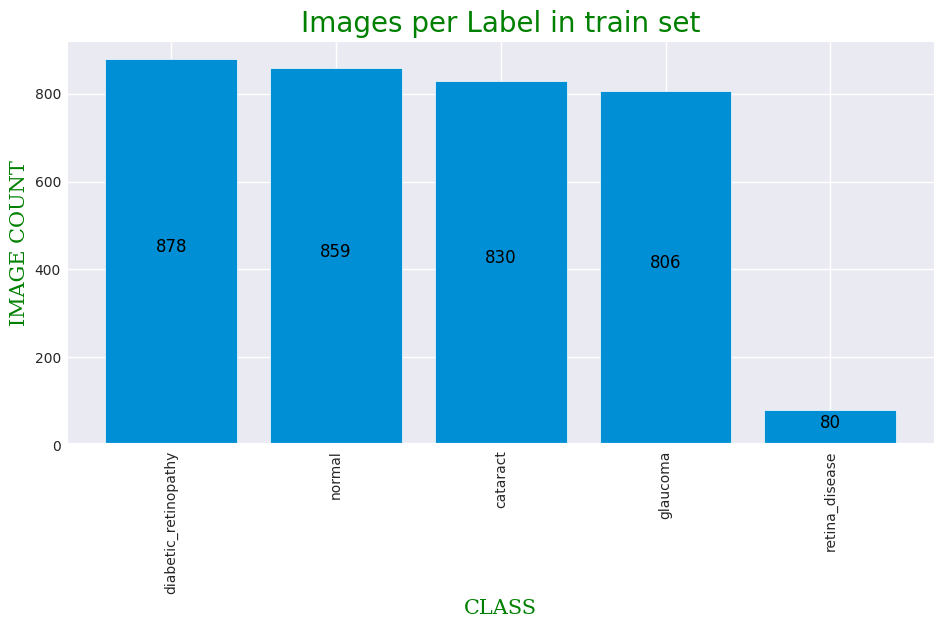

the average height of training images is 224 and average width is 224
  enter the image height to be used to train the model


In [ ]:
working_dir,train_dir, test_dir, valid_dir=run(start=True) # run the classifier
stop = False
while stop == False:
    msg='enter R to rerun the classifier or press enter to quit  '
    print_in_color(msg)
    ans=input(' ')
    if ans == 'R' or ans == 'r':
        msg='press Enter to us original director values '
        print_in_color(msg)
        ans=input(' ')
        if ans == '':
            run(working_dir,train_dir=train_dir, test_dir=test_dir, valid_dir=valid_dir, start=False ) 
        else:
            run(True)
    else:
        stop = True
        print_in_color ('process commpleted')

<a id="Conclusions"></a>
# <center>Evaluate Model Performance</center>
I ran int MobileNetV3 small model with an image size of 200 X 244. After 15 epochs the model achied an F1 score of 73% Next  I ran an EfficientNetB0 model with an image size of 275 X 300. It achieved an F1 score of 94%. 